In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from utils import *

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 20

results = {}

prune_percentages = [70, 50, 30, 20, 15, 10, 8, 5, 3]

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted dimensions here
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)  # Adjusted dimensions here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # Devuelve logits sin procesar

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root="../data/cifar10", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="../data/cifar10", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
def run_experiment():
    global results
    for prune_percentage in prune_percentages:
        print(f"\n{'='*50}")
        print(f"Prunning al {prune_percentage}%")
        print(f"{'='*50}")

        # Crear modelo y guardar estado inicial
        model = Net().to(device)
        initial_state_dict = model.state_dict()
        
        # Contar parámetros totales
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Parámetros totales: {total_params:,}")

        # Entrenar modelo original
        print("Entrenando modelo original...")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)  # LR más bajo para AlexNet
        train_model(model, train_loader, criterion, optimizer, epochs)
        acc_original = evaluate_model(model, test_loader)
        print(f"Accuracy modelo original: {acc_original:.2%}")

        # Pruneo del modelo
        print("Aplicando pruning...")
        prune_mask = create_prune_mask(model, prune_percentage / 100.0)
        model.load_state_dict(initial_state_dict)  # Reiniciar pesos iniciales
        prune_model(model, prune_mask)

        # Verificar porcentaje de pruning
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        zero_params = sum((p == 0).sum().item() for p in model.parameters() if p.requires_grad)
        actual_prune_percentage = (zero_params / total_params) * 100
        print(f"Porcentaje de pesos activos: {actual_prune_percentage:.1f}%")

        # Entrenar modelo pruned con máscara mantenida
        print("Entrenando modelo podado...")
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        train_model_with_mask(model, train_loader, criterion, optimizer, epochs, prune_mask)
        acc_pruned = evaluate_model(model, test_loader)

        # Guardar resultados
        results[prune_percentage] = {
            "accuracy_original": acc_original,
            "accuracy_pruned": acc_pruned,
            "actual_prune_percentage": actual_prune_percentage
        }
        print(f"Accuracy original: {acc_original:.2%}")
        print(f"Accuracy pruned: {acc_pruned:.2%}")
        print(f"Diferencia: {(acc_pruned - acc_original)*100:.2f} puntos porcentuales")

run_experiment()



Prunning al 70%
Parámetros totales: 356,810
Entrenando modelo original...
Accuracy modelo original: 72.12%
Aplicando pruning...
Porcentaje de pesos activos: 69.9%
Entrenando modelo podado...
Accuracy modelo original: 72.12%
Aplicando pruning...
Porcentaje de pesos activos: 69.9%
Entrenando modelo podado...
Accuracy original: 72.12%
Accuracy pruned: 74.12%
Diferencia: 2.00 puntos porcentuales

Prunning al 50%
Parámetros totales: 356,810
Entrenando modelo original...
Accuracy original: 72.12%
Accuracy pruned: 74.12%
Diferencia: 2.00 puntos porcentuales

Prunning al 50%
Parámetros totales: 356,810
Entrenando modelo original...
Accuracy modelo original: 72.52%
Aplicando pruning...
Porcentaje de pesos activos: 49.9%
Entrenando modelo podado...
Accuracy modelo original: 72.52%
Aplicando pruning...
Porcentaje de pesos activos: 49.9%
Entrenando modelo podado...
Accuracy original: 72.52%
Accuracy pruned: 73.35%
Diferencia: 0.83 puntos porcentuales

Prunning al 30%
Parámetros totales: 356,810
E

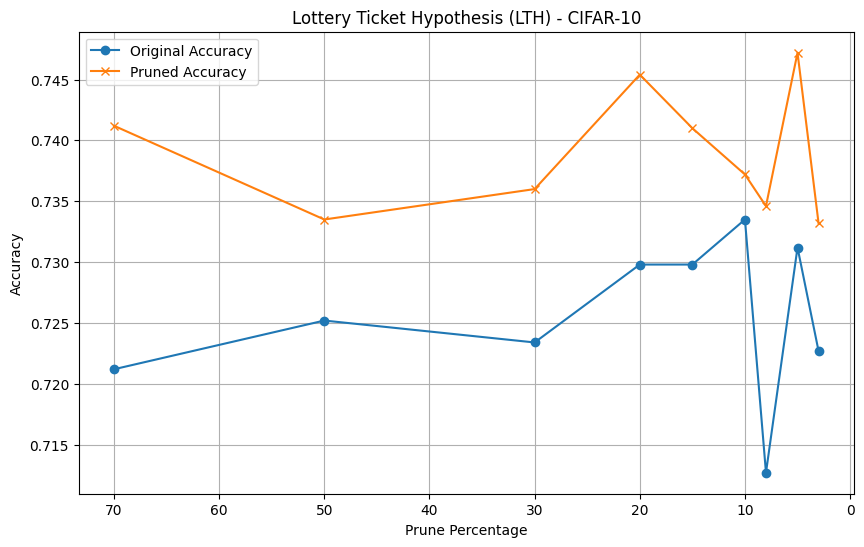

In [11]:
original_accuracies = [results[p]["accuracy_original"] for p in prune_percentages]
pruned_accuracies = [results[p]["accuracy_pruned"] for p in prune_percentages]

plt.figure(figsize=(10, 6))
plt.plot(prune_percentages, original_accuracies, label="Original Accuracy", marker="o")
plt.plot(prune_percentages, pruned_accuracies, label="Pruned Accuracy", marker="x")
plt.gca().invert_xaxis()  # Invertir eje X para visualizar mejor
plt.title("Lottery Ticket Hypothesis (LTH) - CIFAR-10")
plt.xlabel("Prune Percentage")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()